### Initial package imports

In [60]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List, Union
import random

## Initial files being read in and dataset creation

In [61]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [62]:
	# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond

# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates

## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [63]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

main_df['corrected_value_SP500'] = main_df['S&P500_Closing'] * main_df['USD/EUR']
main_df['corrected_value_DAX40'] = main_df['Dax40_Closing']
main_df['corrected_value_NIKKEI'] = main_df['Nikkei_Closing'] * main_df['JPY/EUR']

main_df['C_S&P500_Returns'] = main_df['corrected_value_SP500'].pct_change(fill_method=None)
main_df['C_Dax40_Returns'] = main_df['corrected_value_DAX40'].pct_change(fill_method=None)
main_df['C_Nikkei_Returns'] = main_df['corrected_value_NIKKEI'].pct_change(fill_method=None)

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [64]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

# Methods input values 

### Portfolio change Daily

In [65]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head(20))

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss
0,2012-01-04,5177993.527508,3000000.000000,148957298.907646,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000
1,2012-01-05,5257773.337852,2992362.003093,148448284.084727,1500246.523142,0.782100,0.010120,10107009.688706,107009.688706,-107009.688706
2,2012-01-06,5271256.891210,2973674.436109,148033085.758980,1500493.291886,0.786100,0.010210,10129320.575775,22310.887068,-22310.887068
3,2012-01-09,5264360.708437,2953700.779671,147743109.097356,1500738.323863,0.783300,0.010190,10083515.128156,-45805.447619,45805.447619
4,2012-01-10,5306392.257898,3025245.641449,148305002.535806,1500982.736072,0.782600,0.010190,10190238.934393,106723.806237,-106723.806237
5,2012-01-11,5337200.029565,3020022.743821,149340067.167850,1501223.999292,0.786900,0.010230,10248838.333504,58599.399112,-58599.399112
6,2012-01-12,5300042.482781,3033212.523828,147224573.483201,1501460.534432,0.779600,0.010160,10162387.844425,-86450.489079,86450.489079
7,2012-01-13,5337407.303746,3015477.252088,150702438.893656,1501695.498805,0.789000,0.010260,10274594.136598,112206.292173,-112206.292173
8,2012-01-16,5340789.691137,3053240.176387,148835011.104304,1501930.470054,0.789500,0.010280,10301748.021747,27153.885149,-27153.885149
9,2012-01-17,5328536.427436,3108669.650089,149521157.815087,1502166.395712,0.784900,0.010220,10321310.520566,19562.498819,-19562.498819


In [66]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Value at Risk (VaR)

In [67]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

### Expected Shortfall (ES) 

In [68]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## 1. var/cov multivar normal dist & T-distribution & Historical

### Required functions

In [69]:
def calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df=0):
    """
    Calculate Value at Risk using variance-covariance method.
    
    Parameters:
    - window: DataFrame containing the time window
    - current_date: Current date for reporting
    - vAlpha: Confidence levels (array)
    - mean_loss: Mean loss for the portfolio
    - portfolio_std_loss: Standard deviation of losses
    - df: Degrees of freedom for t-distribution (0 for normal distribution)
    
    Returns:
    - Dictionary with date, VaR and ES values
    """
    # Calculate VaR and ES
    var_result = VaR(vAlpha, mean_loss, portfolio_std_loss, df=df)
    es_result = ES(vAlpha, mean_loss, portfolio_std_loss, df=df)
    
    # Set label for distribution type
    if df == 0:
        dist_label = "Normal"
    else:
        dist_label = f"T{df}"
        
    return {
        'Date': current_date,
        f'VaR {dist_label}': var_result,
        f'ES {dist_label}': es_result
    }

def calculate_historical_var_es(window, current_date, vAlpha):
    """
    Calculate VaR and ES using historical simulation method.
    """
    # Extract portfolio loss values from the window
    historical_losses = window['Portfolio_loss'].dropna()
    
    # Sort losses in ascending order
    sorted_losses = np.sort(historical_losses)
    
    # Calculate VaR for alpha levels
    var_hist = np.percentile(sorted_losses, 100*vAlpha)
    
    # Calculate ES for each alpha level
    es_hist = []
    for i, alpha in enumerate(vAlpha):
        es_hist.append(sorted_losses[sorted_losses >= var_hist[i]].mean())
    
    return {
        'Date': current_date,
        'VaR Historical': var_hist,
        'ES Historical': es_hist
    }

def calculate_multiday_var(vAlpha, interval, sample_size):
    """
    Calculate multi-day VaR using the historical simulation method.

    Parameters:
    - vAlpha: Confidence levels (array)
    - interval: Number of days for the multi-day calculation (e.g., 5 or 10)
    - sample_size: Number of initial rows to skip (burn-in)

    Returns:
    - multi_day_losses_df: DataFrame with multi-day losses and VaR estimates
    """
    # Filter data for the period we want to analyze
    time_window_multi = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')].reset_index(drop=True)
    multi_day_losses = []

    # Calculate rolling sum of losses over the interval, stepping by 'interval'
    for i in range(sample_size, len(time_window_multi) - interval + 1, interval):
        window = time_window_multi.iloc[i:i+interval]
        if len(window) == interval:
            total_loss = window['Portfolio_loss'].sum()
            date = window['Date'].iloc[-1]
            daily_loss = window['Portfolio_loss'].iloc[-1]
            multi_day_losses.append({'Date': date, 'Portfolio_loss': total_loss, 'Daily_loss': daily_loss})

    multi_day_losses_df = pd.DataFrame(multi_day_losses)

    # Calculate VaR as percentiles of the historical multi-day losses up to each row
    var_list = []
    for idx in range(len(multi_day_losses_df)):
        hist_losses = multi_day_losses_df['Portfolio_loss'][:idx+1]
        # For losses, VaR should be negative at high confidence, so use lower percentiles (100*(1-alpha))
        var_row = [np.percentile(hist_losses, 100 * (1 - alpha)) for alpha in vAlpha]
        var_list.append(var_row)
    multi_day_losses_df[f'VaR_{interval}d_reg'] = var_list

    # Calculate VaR per row using the square root of time rule for each alpha level
    sqrt_var_list = []
    for idx in range(len(multi_day_losses_df)):
        hist_daily_losses = multi_day_losses_df['Daily_loss'][:idx+1]
        sqrt_var_row = [np.percentile(hist_daily_losses, 100 * (1 - alpha)) * np.sqrt(interval) for alpha in vAlpha]
        sqrt_var_list.append(sqrt_var_row)
    multi_day_losses_df[f'VaR_{interval}d_sqrt'] = sqrt_var_list

    # drop the first row as it will not have a correct prediction
    multi_day_losses_df = multi_day_losses_df.iloc[1:]
    return multi_day_losses_df[['Date', 'Portfolio_loss', f'VaR_{interval}d_reg', 'Daily_loss', f'VaR_{interval}d_sqrt']]


## GARCH(1,1) with constant conditional correlation 

In [70]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [71]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.02, 0.13, 0.86],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result
    
# result = parameter_estimation_GARCH(main_df['Portfolio_Daily_Returns'].dropna())
# Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [72]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = [0.000002, 0.13, 0.86]
    param = type('obj', (object,), {'x': param})
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)

    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [73]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [74]:
def covariance_matrix(returns, corr_matrix):
    """
    Calculate the covariance matrix using GARCH(1,1) volatilities and a given correlation matrix.
    """
    # Calculate GARCH(1,1) volatilities for each column
    volatilities_dict = {}
    for column in returns.columns:
        column_returns = returns[column].dropna().reset_index(drop=True)
        volatilities_dict[column] = garch_volatility(column_returns)
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Construct the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    return cov_matrix

In [75]:
def portfolio_var_es_and_variance(weights, cov_matrix, alpha=0.99):
    """
    Calculate the portfolio variance, volatility, VaR, and ES using the normal distribution.

    Parameters:
    - weights: array-like, portfolio weights
    - cov_matrix: np.ndarray, covariance matrix
    - alpha: float, confidence level for VaR/ES (default 0.99)

    Returns:
    - dict with keys: 'variance', 'volatility', 'VaR', 'ES'
    """
    # Portfolio variance and volatility
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_volatility = np.sqrt(port_variance)

    # VaR and ES (normal distribution)
    VaR = -port_volatility * st.norm.ppf(alpha)
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))

    return VaR, ES

In [ ]:
# main function to run the analysis
def main_analysis(time_window_size, vAlpha):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []
    corr_matrix = correlation_matrix(main_df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna())
    
    main_df['Portfolio_Daily_Returns'] = (
    weights[0] * main_df['C_S&P500_Returns'] +
    weights[1] * main_df['C_Dax40_Returns'] +
    weights[2] * main_df['C_Nikkei_Returns'] +
    weights[3] * main_df['Interest_Bond_daily_rate']
)

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights_arr = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns, corr_matrix)

        # Calculate the portfolio VaR and ES for each alpha in vAlpha
        VaR_list = []
        ES_list = []
        for alpha in vAlpha:
            VaR, ES = portfolio_var_es_and_variance(weights_arr, cov_matrix, alpha=alpha)
            VaR_list.append(VaR)
            ES_list.append(ES)

        # Append results
        portfolio_VaR_list.append(VaR_list)
        portfolio_ES_list.append(ES_list)
        dates.append(current_date)

    # Create a DataFrame to store the results
    # Calculate daily portfolio returns
    daily_portfolio_returns = main_df['Portfolio_Daily_Returns'][time_window_size:].reset_index(drop=True)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list,
        'Portfolio Daily Returns': daily_portfolio_returns
    })
    return results_df

## EWMA

In [77]:
def compute_ewma_volatility(
    returns: pd.DataFrame, 
    lambdas: List[float] = [0.94, 0.97]
) -> Dict[str, pd.DataFrame]:
    """
    Compute EWMA volatility for each risk factor using different lambda values.

    Parameters:
    ----------
    returns : pd.DataFrame
        DataFrame of returns (T x N), excluding Date column
    lambdas : List[float], optional
        List of smoothing factors, by default [0.94, 0.97]

    Returns:
    -------
    Dict[str, pd.DataFrame]
        Dictionary of DataFrames containing EWMA volatilities for each lambda
    """
    # Input validation
    if not isinstance(returns, pd.DataFrame):
        raise TypeError("returns must be a pandas DataFrame")
    
    # Remove Date column if present
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    
    results = {}
    
    for lambda_ in lambdas:
        n_obs, n_assets = returns.shape
        ewma_vol = np.zeros((n_obs, n_assets))
        
        # Initialize first value with sample standard deviation
        ewma_vol[0] = returns.std().values  # per-asset std dev as initial values

        
        # Loop through time to apply EWMA formula
        for t in range(1, n_obs):
            ewma_vol[t] = np.sqrt(
                lambda_ * ewma_vol[t-1]**2 + 
                (1 - lambda_) * returns.iloc[t-1].values**2
            )
        
        # Store results in dictionary
        results[f'lambda_{lambda_}'] = pd.DataFrame(
            ewma_vol,
            index=returns.index,
            columns=returns.columns
        )
    
    return results

# Example usage
returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                      'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
#set Date as index
returns_df.set_index('Date', inplace=True)
ewma_results = compute_ewma_volatility(returns_df)

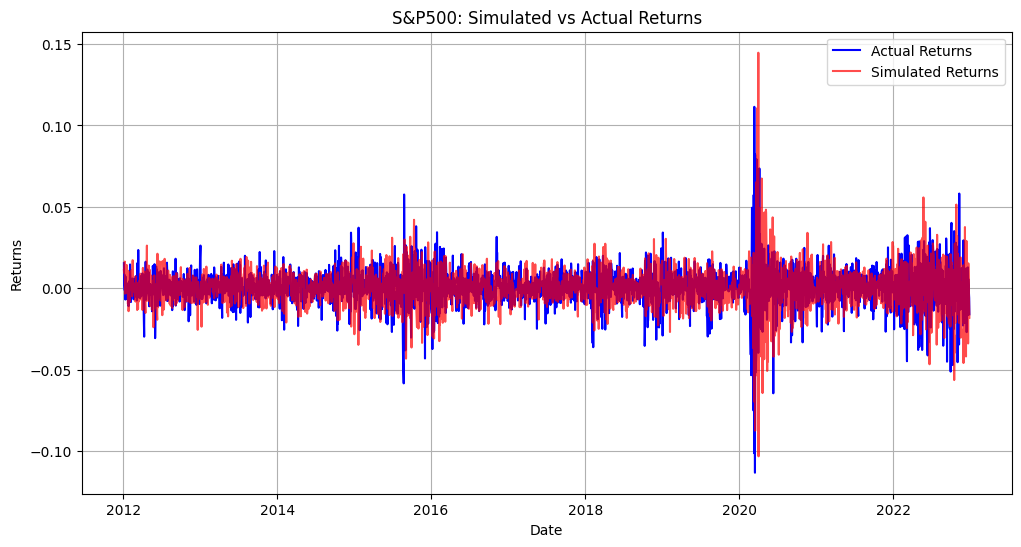

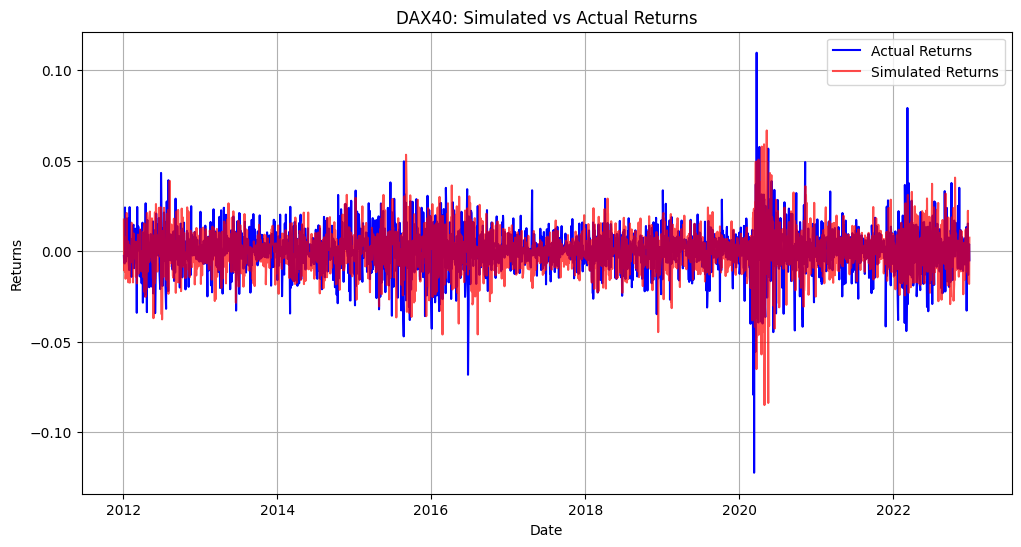

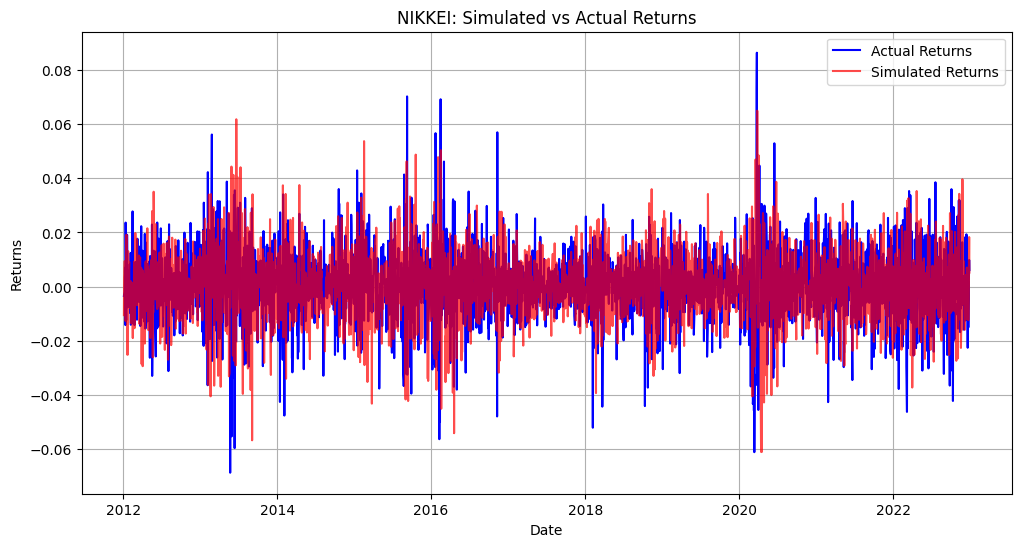

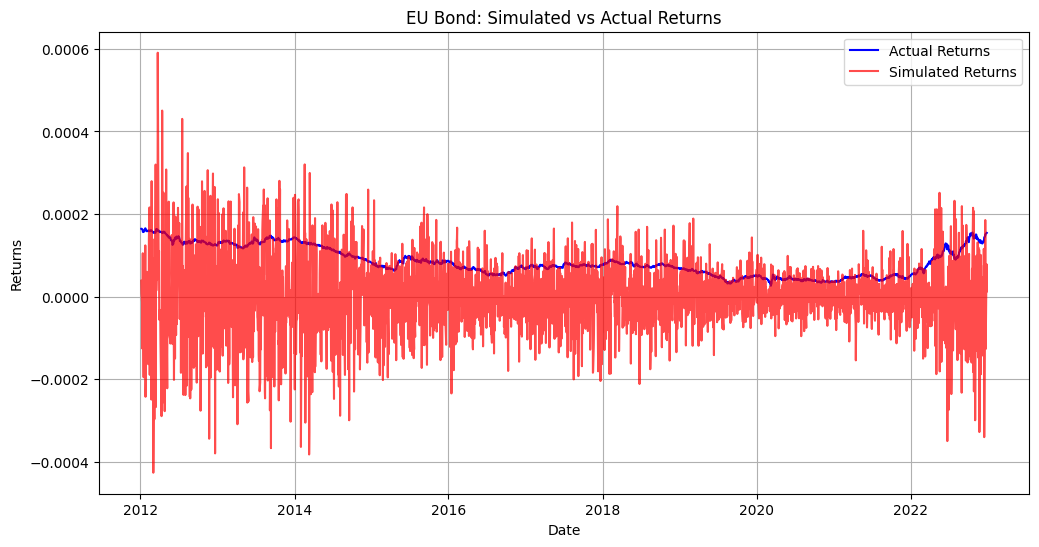

In [78]:
#plot a graphs where you plot the actual returns and the simulated returns to compare them
def plot_simulated_vs_actual_returns(
    actual_returns: pd.Series, 
    simulated_returns: pd.Series, 
    title: str = "Simulated vs Actual Returns"
) -> None:
    """
    Plot simulated returns against actual returns.

    Parameters:
    ----------
    actual_returns : pd.Series
        Series of actual returns
    simulated_returns : pd.Series
        Series of simulated returns
    title : str, optional
        Title of the plot, by default "Simulated vs Actual Returns"
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual_returns.index, actual_returns, label='Actual Returns', color='blue')
    plt.plot(simulated_returns.index, simulated_returns, label='Simulated Returns', color='red', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)
    
    plt.show()
# Example usage
# Simulated returns for S&P500
simulated_returns_sp500 = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_S&P500_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for DAX40
simulated_returns_dax = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_Dax40_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for NIKKEI
simulated_returns_nikkei = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_Nikkei_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for EU Bond
simulated_returns_bond = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['Interest_Bond_daily_rate'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Plot actual vs simulated returns for S&P500
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_S&P500_Returns'], 
    simulated_returns=simulated_returns_sp500, 
    title="S&P500: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for DAX40
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_Dax40_Returns'], 
    simulated_returns=simulated_returns_dax, 
    title="DAX40: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for NIKKEI
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_Nikkei_Returns'], 
    simulated_returns=simulated_returns_nikkei, 
    title="NIKKEI: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for EU Bond
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['Interest_Bond_daily_rate'], 
    simulated_returns=simulated_returns_bond, 
    title="EU Bond: Simulated vs Actual Returns"
)
#plot the actual returns and the simulated returns for all indices in one graph

In [79]:
def filter_returns(returns: pd.DataFrame, ewma_vol: dict) -> dict:
    """
    Compute standardized (filtered) returns for each lambda value.

    Parameters:
    - returns: DataFrame of raw returns
    - ewma_vol: Dictionary containing DataFrames of EWMA volatilities for each lambda

    Returns:
    - filtered_returns: Dictionary of DataFrames with standardized returns for each lambda
    """
    filtered_returns = {}
    
    # Filter returns for each lambda value
    for lambda_key, vol_df in ewma_vol.items():
        filtered_returns[lambda_key] = returns / vol_df
    
    return filtered_returns

# Assuming returns_df and ewma_vol_df (from compute_ewma_volatility) are already defined
filtered_returns_dict = filter_returns(returns_df, ewma_results)

# Preview results for both lambda values
print("\nFiltered Returns (lambda = 0.94):")
print(filtered_returns_dict['lambda_0.94'].tail())
print("\nFiltered Returns (lambda = 0.97):")
print(filtered_returns_dict['lambda_0.97'].tail())



Filtered Returns (lambda = 0.94):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-21          0.800144         1.413978         -0.897532   
2022-12-22         -1.036951        -1.166012          0.148008   
2022-12-23          0.355825         0.170861         -1.145478   
2022-12-27         -0.385142         0.354398          0.741127   
2022-12-28         -1.063447        -0.465302          0.467366   

            Interest_Bond_daily_rate  
Date                                  
2022-12-21                  1.076293  
2022-12-22                  1.093996  
2022-12-23                  1.093727  
2022-12-27                  1.097422  
2022-12-28                  1.096478  

Filtered Returns (lambda = 0.97):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-21          0.726796         1.349856        

In [80]:
def filtered_historical_simulation_multivariate(filtered_returns_dict: dict, ewma_vol_dict: dict,
                                              n_simulations: int = 10000, random_seed: int = None, 
                                              weights: np.ndarray = None) -> dict:
    """
    Perform Filtered Historical Simulation for a multi-asset portfolio for different lambda values.

    Parameters:
    - filtered_returns_dict: Dictionary of DataFrames of standardized residuals for each lambda
    - ewma_vol_dict: Dictionary of DataFrames of EWMA volatility for each lambda
    - n_simulations: number of simulated return vectors
    - random_seed: for reproducibility
    - weights: portfolio weights (numpy array of shape [n_assets])

    Returns:
    - Dictionary containing simulated portfolio returns for each lambda value
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    results = {}
    
    # Process each lambda value
    for lambda_key in filtered_returns_dict.keys():
        filtered_returns = filtered_returns_dict[lambda_key]
        # print(filtered_returns)
        ewma_vol = ewma_vol_dict[lambda_key]
        
        assets = filtered_returns.columns
        n_assets = len(assets)
        
        # Initialize simulated return matrix (n_simulations x n_assets)
        sim_returns = np.zeros((n_simulations, n_assets))

        for i, asset in enumerate(assets):
            if asset == 'Date':
                continue
            z_asset = filtered_returns[asset].dropna().values
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sigma_t = ewma_vol[asset].iloc[-1]  # latest volatility for asset
            sim_returns[:, i] = sigma_t * z_star  # re-scale

        if weights is not None:
            portfolio_simulated_returns = sim_returns @ weights
            results[lambda_key] = pd.Series(portfolio_simulated_returns, 
                                          name=f"Simulated_Portfolio_Returns_{lambda_key}")
        else:
            results[lambda_key] = pd.DataFrame(sim_returns, columns=assets)

    return results

# Define weights in the same order as your DataFrame columns
weights = np.array([0.4, 0.3, 0.15, 0.15])  # Example: S&P500, DAX, Nikkei, Bond rate

# Run multivariate FHS simulation for both lambda values
simulated_returns = filtered_historical_simulation_multivariate(
    filtered_returns_dict,
    ewma_results,
    n_simulations=10000,
    random_seed=42,
    weights=weights
)

# Compute VaR and ES for 95% and 99% for each lambda value
confidence_levels = [0.95, 0.99]
results = {}

for lambda_key, sim_returns in simulated_returns.items():
    for cl in confidence_levels:
        alpha = 1 - cl
        percentile = alpha * 100
        var = -np.percentile(sim_returns, percentile)
        es = -sim_returns[sim_returns <= -var].mean()
        results[f"{lambda_key}_VaR_{int(cl * 100)}"] = var
        results[f"{lambda_key}_ES_{int(cl * 100)}"] = es

# Print results
for lambda_key in simulated_returns.keys():
    print(f"\nResults for {lambda_key}:")
    for cl in confidence_levels:
        print(f"Portfolio 1-day VaR ({int(cl * 100)}%): {results[f'{lambda_key}_VaR_{int(cl * 100)}']:.5f}")
        print(f"Portfolio 1-day ES  ({int(cl * 100)}%): {results[f'{lambda_key}_ES_{int(cl * 100)}']:.5f}")




Results for lambda_0.94:
Portfolio 1-day VaR (95%): 0.01182
Portfolio 1-day ES  (95%): 0.01681
Portfolio 1-day VaR (99%): 0.01989
Portfolio 1-day ES  (99%): 0.02439

Results for lambda_0.97:
Portfolio 1-day VaR (95%): 0.01304
Portfolio 1-day ES  (95%): 0.01877
Portfolio 1-day VaR (99%): 0.02248
Portfolio 1-day ES  (99%): 0.02788


In [81]:
def filtered_historical_simulation_multiday(
    filtered_returns_dict: dict,
    ewma_vol_dict: dict,
    lambda_key: str,
    n_days: int = 1,
    n_simulations: int = 10000,
    random_seed: int = None,
    weights: np.ndarray = None
) -> pd.Series:
    """
    Simulate N-day portfolio returns using Filtered Historical Simulation.

    Returns:
    - Simulated N-day portfolio return series (n_simulations,)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    filtered_returns = filtered_returns_dict[lambda_key]
    ewma_vol = ewma_vol_dict[lambda_key]

    assets = filtered_returns.columns
    n_assets = len(assets)
    sim_returns = np.zeros((n_simulations, n_days, n_assets))

    for i, asset in enumerate(assets):
        z_asset = filtered_returns[asset].dropna().values
        sigma_t = ewma_vol[asset].iloc[-1]

        if len(z_asset) == 0 or np.isnan(sigma_t):
            raise ValueError(f"Cannot simulate for asset '{asset}': empty or invalid data.")

        for day in range(n_days):
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sim_returns[:, day, i] = sigma_t * z_star

    # Combine all simulated daily returns into N-day portfolio PnL
    total_pnl = (sim_returns @ weights).sum(axis=1)

    return pd.Series(total_pnl, name=f"Simulated_{n_days}Day_Returns_{lambda_key}")


# Example usage with both lambda values
confidence_levels = [0.95, 0.99]
horizons = [1, 5, 10]
lambda_keys = ['lambda_0.94', 'lambda_0.97']

for lambda_key in lambda_keys:
    print(f"\n=== Results for {lambda_key} ===")
    for days in horizons:
        print(f"\n--- {days}-Day VaR & ES ---")
        sim_returns = filtered_historical_simulation_multiday(
            filtered_returns_dict,
            ewma_results,
            lambda_key,
            n_days=days,
            n_simulations=10000,
            random_seed=42,
            weights=weights
        )

        for cl in confidence_levels:
            alpha = 1 - cl
            percentile = alpha * 100
            var = -np.percentile(sim_returns, percentile)
            es = -sim_returns[sim_returns <= -var].mean()
            print(f"VaR ({int(cl*100)}%): {var:.5f} | ES ({int(cl*100)}%): {es:.5f}")



=== Results for lambda_0.94 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01182 | ES (95%): 0.01681
VaR (99%): 0.01989 | ES (99%): 0.02439

--- 5-Day VaR & ES ---
VaR (95%): 0.02633 | ES (95%): 0.03504
VaR (99%): 0.04117 | ES (99%): 0.04748

--- 10-Day VaR & ES ---
VaR (95%): 0.03528 | ES (95%): 0.04650
VaR (99%): 0.05320 | ES (99%): 0.06286

=== Results for lambda_0.97 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01279 | ES (95%): 0.01836
VaR (99%): 0.02171 | ES (99%): 0.02719

--- 5-Day VaR & ES ---
VaR (95%): 0.02829 | ES (95%): 0.03832
VaR (99%): 0.04543 | ES (99%): 0.05256

--- 10-Day VaR & ES ---
VaR (95%): 0.03862 | ES (95%): 0.05026
VaR (99%): 0.05785 | ES (99%): 0.06803


In [82]:
def rolling_fhs_multiday_var_es(
    returns_df: pd.DataFrame,
    weights: np.ndarray,
    window_size: int = 500,
    horizons: list = [1, 5, 10],
    confidence_levels: list = [0.95, 0.99],
    n_simulations: int = 1000,
    lambdas: list = [0.94, 0.97],
    random_seed: int = None
) -> tuple:
    """
    Rolling Filtered Historical Simulation for multi-day VaR & ES.
    """
    time_window = returns_df.loc['2012-01-05':'2021-12-31']

    var_results = []
    es_results = []

    for horizon in horizons:
        #adjusted_window_size = int(window_size / horizon)

        for t in range(window_size, len(time_window)):
            current_date = time_window.index[t]
            var_row = {'index': current_date}
            es_row = {'index': current_date}

            window = time_window.iloc[t - window_size:t]


            try:
                # Compute EWMA vol
                ewma_results = compute_ewma_volatility(
                    window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']],
                    lambdas
                )
                # Filtered returns
                filtered_returns_dict = {}
                for lambda_key, vol_df in ewma_results.items():
                    safe_vol_df = vol_df.replace(0, np.nan).ffill()
                    filtered_returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']] / safe_vol_df
                    filtered_returns_dict[lambda_key] = filtered_returns

                # Simulate for each lambda and confidence level
                for lambda_key in ewma_results.keys():
                    sim_returns = filtered_historical_simulation_multiday(
                        filtered_returns_dict,
                        ewma_results,
                        lambda_key,
                        n_days=horizon,
                        n_simulations=n_simulations,
                        weights=weights,
                        random_seed=random_seed
                    )

                    for cl in confidence_levels:
                        alpha = 1 - cl
                        var = np.percentile(sim_returns, 100 * alpha)
                        es = sim_returns[sim_returns <= var].mean()

                        var_key = f"VaR_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        es_key = f"ES_{int(cl * 100)}_{lambda_key}_h{horizon}"

                        var_row[var_key] = var
                        es_row[es_key] = es

                var_results.append(var_row)
                es_results.append(es_row)

            except Exception as e:
                continue

    var_df = pd.DataFrame(var_results).set_index('index')
    es_df = pd.DataFrame(es_results).set_index('index')

    var_df.index.name = 'Date'
    es_df.index.name = 'Date'

    return var_df, es_df

In [83]:
def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Plot VaR and ES against already computed actual portfolio returns and mark violations.

    Parameters:
    - var_df: DataFrame of rolling VaR values
    - es_df: DataFrame of rolling ES values
    - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
    - lambdas: list of lambda values used (e.g. [0.94, 0.97])
    - horizons: list of horizon days (e.g. [1, 5, 10])
    - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
    """

    for h in horizons:
        actual_returns = actual_returns_dict[h].reindex(var_df.index).sort_index()
        actual_returns = actual_returns[~actual_returns.index.duplicated(keep='first')]  

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"
            plt.figure(figsize=(14, 5))
            plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)

            title_addon = ""

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
                var_series = var_df[var_col]
                plt.plot(var_series, label=f"VaR {int(cl * 100)}%", linestyle='--')

                # Find violations
                actual_aligned, var_aligned = actual_returns.align(var_series, join='inner')
                violations = actual_aligned < var_aligned
                violation_points = actual_aligned[violations]


                # Mark violations with different styles
                if cl == 0.95:
                    plt.scatter(violation_points.index, violation_points, 
                                color='red', label="VaR 95% Violation", marker='x', s=50)
                elif cl == 0.99:
                    plt.scatter(violation_points.index, violation_points, 
                                color='purple', label="VaR 99% Violation", marker='v', s=60)

                # Count violations and append to title
                total_obs = actual_returns.dropna().shape[0]
                violation_count = len(violation_points)
                percentage = violation_count / total_obs * 100
                title_addon += f" | {int(cl*100)}% Viol: {violation_count} ({percentage:.2f}%)"

            plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_}{title_addon}")
            plt.axhline(0, color='gray', linestyle='-')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [84]:
def compute_actual_portfolio_returns(returns_df, weights, horizons=[1, 5, 10]):
    actual_returns = {}
    weighted_returns = returns_df @ weights

    for h in horizons:
        actual_returns[h] = weighted_returns.rolling(window=h).sum().shift(-h + 1)
        actual_returns[h].name = f"Actual_{h}d"

    return actual_returns

actual_returns_dict = compute_actual_portfolio_returns(returns_df, weights)
returns_dfe = pd.DataFrame(actual_returns_dict)




# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [85]:
def calculate_violations(negative_actual_returns, var_predictions):
    """Checks for VaR violations. Violation occurs if negative return is less than negative VaR."""
    # var_predictions are typically positive loss values, so compare negative return to -VaR
    return negative_actual_returns < -var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    # Expected violations based on the confidence level (1 - alpha)
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(negative_actual_returns, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(negative_actual_returns, pd.Series):
        negative_actual_returns = pd.Series(negative_actual_returns, index=dates)
    elif negative_actual_returns.index.name != 'Date':
        negative_actual_returns = negative_actual_returns.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Negative_Return': negative_actual_returns,
        'Violation': violations,
        'Predicted_ES': es_predictions, # Assumed positive loss value
        'Year': negative_actual_returns.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    # Actual shortfall is the loss on violation days, which is -Negative_Return
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Negative_Return'].apply(lambda x: -x.mean())
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    # Handle years with no violations (results in NaN means)
    summary = summary.fillna({'Avg Actual Shortfall': 0, 'Avg Predicted ES': 0})
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    # Ensure violations is boolean or 0/1 for plotting
    plot_data = violations.astype(int)
    plt.plot(dates, plot_data, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.ylim(-0.1, 1.1) # Adjust y-axis limits
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models using negative returns."""
    # Align main_df with var/es results (which start after the initial window)
    # Ensure 'Date' column exists and is suitable for merging/indexing
    if 'Date' not in var_results_df.columns or 'Date' not in es_results_df.columns or 'Date' not in main_df.columns:
        raise ValueError("All input DataFrames must contain a 'Date' column.")
        
    # Use merge to ensure alignment and handle potential missing dates
    backtest_base = pd.merge(var_results_df[['Date']], main_df[['Date', 'Portfolio_loss']], on='Date', how='left')
    backtest_base = backtest_base.set_index('Date')
    
    # Calculate negative actual returns
    negative_actual_returns = -backtest_base['Portfolio_loss']
    backtest_dates = negative_actual_returns.index # Use index from aligned data

    # Confidence levels used (assuming 95% and 99%)
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    # Ensure Date columns are handled correctly
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']
    
    # Align var_results_df and es_results_df to the backtest_dates
    var_results_aligned = var_results_df.set_index('Date').reindex(backtest_dates)
    es_results_aligned = es_results_df.set_index('Date').reindex(backtest_dates)

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model from aligned dataframes
        var_preds_list = var_results_aligned[model_name].tolist()
        es_preds_list = None
        # Find matching ES column (handle potential naming differences)
        matching_es_col = model_name.replace('VaR', 'ES')
        if matching_es_col in es_results_aligned.columns:
            es_preds_list = es_results_aligned[matching_es_col].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            try:
                # Handle cases where predictions might be NaN or not list/array
                var_predictions = pd.Series([p[alpha_idx] if isinstance(p, (list, np.ndarray)) and len(p) > alpha_idx else np.nan for p in var_preds_list], index=backtest_dates)
                es_predictions = None
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] if isinstance(p, (list, np.ndarray)) and len(p) > alpha_idx else np.nan for p in es_preds_list], index=backtest_dates)
                
                # Drop NaN predictions and corresponding actual returns for fair backtesting
                valid_idx = var_predictions.notna()
                if es_predictions is not None:
                    valid_idx = valid_idx & es_predictions.notna()
                
                var_predictions_clean = var_predictions[valid_idx]
                es_predictions_clean = es_predictions[valid_idx] if es_predictions is not None else None
                negative_actual_returns_clean = negative_actual_returns[valid_idx]
                backtest_dates_clean = backtest_dates[valid_idx]
                
                if negative_actual_returns_clean.empty:
                    print("  No valid data points for backtesting after cleaning NaNs. Skipping.")
                    continue
                    
            except Exception as e:
                print(f"  Error processing predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(negative_actual_returns_clean, var_predictions_clean)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates_clean)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions_clean is not None:
                es_summary = backtest_es(negative_actual_returns_clean, violations, es_predictions_clean, backtest_dates_clean)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates_clean, f'VaR Violations for {model_name} (alpha={alpha})')

In [89]:
def main():
    # Initialize lists to store results
    VaR_results = []
    ES_results = []
    # Define time window
    time_window = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')]

    # Define confidence levels
    vAlpha = np.array([0.95, 0.99])
    
    # Define sample size and t-distribution degrees of freedom
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
    
    for i in range(sample_size, len(time_window)):
        # Extract the rolling window
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate loss statistics
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"]
        
        # Initialize result dictionaries for this date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}

        # Calculate VaR and ES using various distributions
        for df in degrees_of_freedom:
            results = calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df)
            # Get the distribution label
            if df == 0:
                dist_label = "Normal"
            else:
                dist_label = f"T{df}"
            # Add results to the dictionaries
            var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
            es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
        
        # Calculate VaR and ES using historical simulation
        hist_results = calculate_historical_var_es(window, current_date, vAlpha)
        var_row['VaR Historical'] = hist_results['VaR Historical']
        es_row['ES Historical'] = hist_results['ES Historical']
        
        # Add results for this date
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert results to DataFrame
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Example usage
    returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                        'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
    #set Date as index
    returns_df.set_index('Date', inplace=True)

    # Calculate VaR and ES using rolling FHS
    var_df, es_df = rolling_fhs_multiday_var_es(
        returns_df=returns_df,  # DataFrame containing returns
        weights=weights,        # Portfolio weights
        window_size=500,       # Base window size
        horizons=[1],   # Horizons for VaR calculation
        confidence_levels=[0.95, 0.99],  # Confidence levels
        n_simulations=1000,    # Number of simulations
        lambdas=[0.94, 0.97]   # EWMA lambda values
    )

    # Align indices for merging
    var_results_df = var_results_df.copy()
    es_results_df = es_results_df.copy()

    # Ensure 'Date' is datetime and set as index for alignment
    var_results_df['Date'] = pd.to_datetime(var_results_df['Date'])
    es_results_df['Date'] = pd.to_datetime(es_results_df['Date'])
    var_results_df.set_index('Date', inplace=True)
    es_results_df.set_index('Date', inplace=True)

    # Add FHS VaR and ES columns as lists [95, 99] for each lambda
    for lambda_ in [0.94, 0.97]:
        var_col_95 = f'VaR_95_lambda_{lambda_}_h1'
        var_col_99 = f'VaR_99_lambda_{lambda_}_h1'
        es_col_95 = f'ES_95_lambda_{lambda_}_h1'
        es_col_99 = f'ES_99_lambda_{lambda_}_h1'

        # Align var_df/es_df to var_results_df by Date
        aligned_var = var_df.loc[var_results_df.index, [var_col_95, var_col_99]]
        aligned_es = es_df.loc[es_results_df.index, [es_col_95, es_col_99]]

        # Combine [95,99] into a list for each row
        var_results_df[f'VaR FHS λ={lambda_}'] = aligned_var.values.tolist()
        es_results_df[f'ES FHS λ={lambda_}'] = aligned_es.values.tolist()

    # Reset index to restore 'Date' as a column
    var_results_df.reset_index(inplace=True)
    es_results_df.reset_index(inplace=True)

    # Insert the GARCH values into var_results_df and es_results_df using the main_analysis function
    garch_results_df = main_analysis(500, vAlpha=[0.95, 0.99])

    # Ensure 'Date' is datetime for alignment
    garch_results_df['Date'] = pd.to_datetime(garch_results_df['Date'])

    # Align GARCH results to var_results_df by Date
    aligned_garch = garch_results_df.set_index('Date').reindex(var_results_df['Date'])

    # Add GARCH VaR and ES columns as lists [95, 99] for each row
    var_results_df['VaR GARCH'] = aligned_garch['Portfolio VaR'].tolist()
    es_results_df['ES GARCH'] = aligned_garch['Portfolio ES'].tolist()

    var_5d = calculate_multiday_var(vAlpha, 5, sample_size)
    var_10d = calculate_multiday_var(vAlpha, 10, sample_size)

    return var_results_df, es_results_df, var_5d, var_10d

In [90]:
var_results_df, es_results_df, var_5d, var_10d = main()
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())
print("5-day VaR results")
display(var_5d.head())
print("10-day VaR results")
display(var_10d.head())

VaR results


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical,VaR FHS λ=0.94,VaR FHS λ=0.97,VaR GARCH
0,2013-12-18,"[113330.33890999507, 162204.12991336812]","[92809.7271860876, 183376.60297623335]","[103475.87176200934, 185378.60862401797]","[107305.94833689781, 182292.80418971393]","[109152.64716166742, 179389.35642265293]","[108659.04898719526, 168858.9889832511]","[-0.006056986801803616, -0.009096509472899703]","[-0.005681403647165749, -0.009266651318122404]","[-0.009249533393319161, -0.013081791590962412]"
1,2013-12-19,"[113720.60336117359, 162826.14840203812]","[93102.68519712356, 184099.01895843237]","[103819.40743479792, 186110.51789254547]","[107667.6458033985, 183010.08091957652]","[109523.101466954, 180092.86532872188]","[108659.04898719526, 168858.9889832511]","[-0.005846944674577532, -0.008437583454861512]","[-0.006033883640833451, -0.01002522657721829]","[-0.009103371063006162, -0.012875071417922643]"
2,2013-12-20,"[113819.42424496396, 163046.6202441909]","[93150.42855999427, 184372.1908589625]","[103893.69972467133, 186388.67295277535]","[107751.47147458674, 183280.55515417273]","[109611.5237261545, 180356.11263869924]","[108659.04898719526, 168858.9889832511]","[-0.005968872363658708, -0.00991778233827337]","[-0.0064684515317224205, -0.010751933988814409]","[-0.011276435792624802, -0.01594847833454344]"
3,2013-12-23,"[113615.08479781616, 162839.52545929916]","[92947.24599498825, 184163.90244220864]","[103689.91583879109, 186180.27166976716]","[107547.47166204454, 183072.32783830017]","[109407.41980302727, 180148.049009315]","[108659.04898719526, 168858.9889832511]","[-0.007389825264065024, -0.009617324451301682]","[-0.005871062819683892, -0.009420856235571168]","[-0.011562356205774293, -0.016352861031201968]"
4,2013-12-24,"[113539.27286558475, 162682.7158400985]","[92905.44251699596, 183972.004050267]","[103630.43554421073, 185985.05538855516]","[107481.64384792227, 182882.22560730786]","[109338.5314869414, 179962.75861199756]","[108659.04898719526, 168858.9889832511]","[-0.0064378210060782514, -0.010741769953453096]","[-0.006581201408270265, -0.01051745023025651]","[-0.011032250557258549, -0.015603122496273943]"


ES results


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical,ES FHS λ=0.94,ES FHS λ=0.97,ES GARCH
0,2013-12-18,"[143297.37435681708, 186506.14428563858]","[155782.8211996487, 285331.5107293555]","[157788.13273535238, 260107.63012874193]","[155917.27805607973, 242704.1303941082]","[154097.4588670344, 231495.57246617432]","[159180.56501425646, 236960.7493751094]","[-0.008014527850312248, -0.011266772764493798]","[-0.007999601474420925, -0.01083483727818602]","[-0.011599288034661056, -0.014987344483123983]"
1,2013-12-19,"[143829.7391303539, 187243.40020186073]","[156374.3905623182, 286537.38545352576]","[158389.2110605003, 261193.8960390595]","[156509.4849980879, 243707.87085986382]","[154681.03643047574, 232446.1632068743]","[159180.56501425646, 236960.7493751094]","[-0.007644450137864662, -0.01100414087706764]","[-0.008386695915342584, -0.011770212421589604]","[-0.011415994575734546, -0.014750512515314743]"
2,2013-12-20,"[144003.15047472744, 187524.36179276908]","[156578.87922938005, 287064.3316568733]","[158598.69111589371, 261658.05789141465]","[156714.30833952443, 244128.71394405887]","[154881.33008956417, 232839.10725181332]","[159180.56501425646, 236960.7493751094]","[-0.008357526690429405, -0.011470374669966178]","[-0.00898915618304112, -0.013238401447928788]","[-0.014141105415921952, -0.018271605775050968]"
3,2013-12-23,"[143797.12158826776, 187315.89694314363]","[156372.14645598567, 286850.2953699471]","[158391.8452898703, 261445.4436408978]","[156507.56798591083, 243917.08084353493]","[154674.69233115335, 232628.10605157953]","[159180.56501425646, 236960.7493751094]","[-0.009182186541852424, -0.012331095846238978]","[-0.008379135989380717, -0.012545732864493692]","[-0.014499661149069061, -0.018734892683093668]"
4,2013-12-24,"[143671.64580744418, 187118.812016617]","[156225.97876045108, 286489.4288760099]","[158242.35422627462, 261126.38024721327]","[156361.17745735782, 243626.85996840138]","[154531.31775740944, 232356.46092528367]","[159180.56501425646, 236960.7493751094]","[-0.00899770452332802, -0.012703068406263377]","[-0.00920006281147505, -0.013530829690259654]","[-0.013834887279462173, -0.017875943844388596]"


5-day VaR results


,Date,Portfolio_loss,VaR_5d_reg,Daily_loss,VaR_5d_sqrt
1,2014-01-03,-81177.818929,"[-414216.9577194172, -428239.6583000708]",-92990.692634,"[-199835.23888314053, -206313.8557805108]"
2,2014-01-10,41263.300701,"[-396688.5819936001, -424733.9831549074]",4708.202095,"[-191736.9677614277, -204694.20155616823]"
3,2014-01-17,-228822.767349,"[-401306.94853081094, -425657.6564623496]",-69168.369914,"[-199943.26005729765, -206335.46001534222]"
4,2014-01-24,415799.173372,"[-391160.8202260032, -423628.430801388]",209461.894353,"[-197279.8434081124, -205802.77668550517]"
5,2014-01-31,-81828.807162,"[-381014.6919211954, -421599.20514042646]",-9164.235534,"[-194616.4267589272, -205270.09335566816]"


10-day VaR results


,Date,Portfolio_loss,VaR_10d_reg,Daily_loss,VaR_10d_sqrt
1,2014-01-17,-187559.466648,"[-496654.9680878221, -509669.5155168667]",-69168.369914,"[-290295.74997317727, -293309.0619311997]"
2,2014-01-31,333970.366209,"[-480386.7838015163, -506415.8786596056]",-9164.235534,"[-286529.11002564913, -292555.733941694]"
3,2014-02-14,-92408.789960,"[-464118.5995152105, -503162.2418023444]",-35767.376925,"[-282762.47007812106, -291802.4059521885]"
4,2014-02-28,-20790.775529,"[-447850.41522890475, -499908.60494508327]",19973.877241,"[-278995.83013059304, -291049.0779626829]"
5,2014-03-14,497100.838746,"[-431582.23094259895, -496654.9680878221]",67211.409280,"[-275229.19018306496, -290295.74997317727]"


In [ ]:
#perform backtesting
run_backtesting(main_df, var_results_df, es_results_df)

In [ ]:
# Function to plot VaR (and ES if available) vs actual returns with violations
def plot_var_with_violations(var_type, var_data_column, es_data_column, var_results_df, es_results_df, main_df, title_prefix, window='1d'):
    """
    Plots VaR (and ES if available) vs actual returns with violations.
    For multi-day VaR (e.g., 5d, 10d), ES is not plotted.
    - window: '1d', '5d', or '10d'
    """
    plt.figure(figsize=(12, 6))
    
    # Align dataframes by Date index
    var_df_indexed = var_results_df.set_index('Date')
    es_df_indexed = es_results_df.set_index('Date')
    main_df_indexed = main_df.set_index('Date')
    
    # Use intersection of indices to ensure alignment
    common_index = var_df_indexed.index.intersection(main_df_indexed.index)
    if es_data_column in es_df_indexed.columns:
        common_index = common_index.intersection(es_df_indexed.index)
        
    var_aligned = var_df_indexed.loc[common_index]
    es_aligned = es_df_indexed.loc[common_index] if es_data_column in es_df_indexed.columns else None
    main_aligned = main_df_indexed.loc[common_index]
    
    # Extract the values for different confidence levels from the arrays/lists
    # Handle potential errors if data isn't list/array or has wrong length
    def safe_extract(series, index):
        try:
            return series.apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) and len(x) > index else np.nan)
        except Exception:
            return pd.Series(np.nan, index=series.index)
            
    var_95 = safe_extract(var_aligned[var_data_column], 0)
    var_99 = safe_extract(var_aligned[var_data_column], 1)
    es_95 = safe_extract(es_aligned[es_data_column], 0) if es_aligned is not None else pd.Series(np.nan, index=common_index)
    es_99 = safe_extract(es_aligned[es_data_column], 1) if es_aligned is not None else pd.Series(np.nan, index=common_index)
    
    # Use negative portfolio loss as actual returns for comparison
    actual_returns = -main_aligned['Portfolio_loss']
    
    # Combine into a single DataFrame for easier plotting and violation calculation
    plot_df = pd.DataFrame({
        'Actual_Returns': actual_returns,
        'VaR_95': var_95,
        'VaR_99': var_99,
        'ES_95': es_95,
        'ES_99': es_99
    }).dropna(subset=['Actual_Returns', 'VaR_95', 'VaR_99']) # Drop rows where essential data is missing

    # Calculate violations for VaR (Actual Return < -VaR)
    violations_95 = plot_df['Actual_Returns'] < -plot_df['VaR_95']
    violations_99 = plot_df['Actual_Returns'] < -plot_df['VaR_99']

    violation_pct_95 = violations_95.mean() * 100 if not plot_df.empty else 0
    violation_pct_99 = violations_99.mean() * 100 if not plot_df.empty else 0

    plt.plot(plot_df.index, plot_df['Actual_Returns'], label='Actual Portfolio Returns', color='blue', alpha=0.6)
    plt.plot(plot_df.index, -plot_df['VaR_95'], 
                label=f'VaR {var_type} 95% ({violation_pct_95:.2f}% violations)', 
                color='red', linestyle='--', linewidth=1.5)
    plt.plot(plot_df.index, -plot_df['VaR_99'], 
                label=f'VaR {var_type} 99% ({violation_pct_99:.2f}% violations)', 
                color='darkred', linestyle='-.', linewidth=1.5)
    
    # Only plot ES if data is available
    if not plot_df['ES_95'].isna().all():
        plt.plot(plot_df.index, -plot_df['ES_95'], 
                    label=f'ES {var_type} 95%', 
                    color='orange', linestyle='--', linewidth=1.5)
    if not plot_df['ES_99'].isna().all():
        plt.plot(plot_df.index, -plot_df['ES_99'], 
                    label=f'ES {var_type} 99%', 
                    color='purple', linestyle='-.', linewidth=1.5)

    # Get violation points for scattering
    violation_points_95 = plot_df[violations_95]
    violation_points_99 = plot_df[violations_99]

    plt.scatter(violation_points_95.index, violation_points_95['Actual_Returns'], 
                color='red', marker='o', s=50, label='95% VaR Violation', zorder=5)
    plt.scatter(violation_points_99.index, violation_points_99['Actual_Returns'], 
                color='darkred', marker='x', s=80, label='99% VaR Violation', zorder=5)

    plt.title(f'{title_prefix} and ES ({var_type} Distribution) vs Actual Portfolio Returns')
    print(f"95% VaR {var_type}: {violations_95.sum()} violations out of {len(plot_df)} days ({violation_pct_95:.2f}%)")
    print(f"99% VaR {var_type}: {violations_99.sum()} violations out of {len(plot_df)} days ({violation_pct_99:.2f}%)")


    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_var_multiday_methods(var_df, main_df, horizon, confidence_levels=[0.95, 0.99]):
    """
    Plot multi-day VaR (5d or 10d) for both 'reg' and 'sqrt' methods vs actual portfolio returns.
    No violations are assessed or plotted.

    Parameters:
    - var_df: DataFrame with VaR columns (e.g., VaR_5d_reg, VaR_5d_sqrt, VaR_10d_reg, VaR_10d_sqrt)
    - main_df: DataFrame with actual portfolio returns/losses and Date column
    - horizon: int, 5 or 10 (number of days)
    - confidence_levels: list of confidence levels (default [0.95, 0.99])
    """
    methods = ['reg', 'sqrt']
    colors = {'reg': ['red', 'darkred'], 'sqrt': ['orange', 'purple']}
    linestyles = {'reg': '--', 'sqrt': '-.'}
    labels = {'reg': 'Historical', 'sqrt': 'Sqrt Rule'}

    # Align actual returns from main_df
    # Use negative portfolio loss for consistency
    actual_returns = -main_df.set_index('Date')['Portfolio_loss']
    
    # Align var_df
    var_df_indexed = var_df.set_index('Date')
    
    # Use intersection of indices
    common_index = actual_returns.index.intersection(var_df_indexed.index)
    actual_returns_aligned = actual_returns.loc[common_index]
    var_df_aligned = var_df_indexed.loc[common_index]
    
    if actual_returns_aligned.empty or var_df_aligned.empty:
        print(f"No common dates found for plotting {horizon}-day VaR. Skipping.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(actual_returns_aligned.index, actual_returns_aligned, label=f'Actual {horizon}d Portfolio Return', color='blue', alpha=0.6)

    for method in methods:
        var_col = f'VaR_{horizon}d_{method}'
        if var_col not in var_df_aligned.columns:
            continue
            
        # Define safe_extract locally or ensure it's accessible
        def safe_extract(series, index):
            try:
                return series.apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) and len(x) > index else np.nan)
            except Exception:
                return pd.Series(np.nan, index=series.index)
                
        for idx, cl in enumerate(confidence_levels):
            alpha_idx = 0 if cl == 0.95 else 1
            # Apply safe_extract to the aligned DataFrame column
            var_vals = safe_extract(var_df_aligned[var_col], alpha_idx)
            plt.plot(var_df_aligned.index, -var_vals, # Plot negative VaR
                        label=f'VaR {horizon}d {int(cl*100)}% ({labels[method]})', 
                        color=colors[method][idx], linestyle=linestyles[method])

    plt.title(f'{horizon}-Day VaR (Historical & Sqrt Rule) vs Actual Portfolio Returns')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# # Plot for Normal Distribution
# plot_var_with_violations("Normal", "VaR Normal", "ES Normal", var_results_df, es_results_df, main_df, "Parametric VaR")

# # Plot for T3 Distribution
# plot_var_with_violations("T3", "VaR T3", "ES T3", var_results_df, es_results_df, main_df, "Parametric VaR")

# # Plot for Historical Distribution
# plot_var_with_violations("Historical", "VaR Historical", "ES Historical", var_results_df, es_results_df, main_df, "Historical VaR")

# Plot for 5-day VaR
plot_var_multiday_methods(var_5d, main_df, 5, confidence_levels=[0.95, 0.99])

# Plot for 10-day VaR
plot_var_multiday_methods(var_10d, main_df, 10, confidence_levels=[0.95, 0.99])


# Stress Testing

For stress testing, different extreme changes are tested to measure their effect on the VaR and ES in the portfolio. We simulate these stresses by modifying the historical data over short, randomly selected periods and then re-evaluating the risk measures.

**Scenarios:**
1.  **Equity Stress:** Equity index returns changing by +/- 20% and +/- 40%.
2.  **Currency Stress:** USD/EUR and JPY/EUR exchange rates moving by +/- 10%.
3.  **Commodity Stress:** Interpreted as equity index returns changing by +/- 20% and +/- 40% (proxy for commodity impact).
4.  **Interest Rate Stress:** 10-year government bond yield shifting by +/- 2% and +/- 3% (absolute shift).

**Methodology:**
- Stresses are applied over randomly selected periods (max 4 consecutive days).
- Each scenario type (e.g., Equity +20%) is applied 5 times to different random periods.
- After applying stress to the underlying data, all dependent portfolio metrics (bond values, investment values, portfolio value, losses, returns) are recalculated.
- The VaR and ES calculations (using the previously defined `main` function) are re-run on the stressed dataset.
- Results are compared to the baseline (unstressed) VaR and ES.

In [ ]:
def select_stress_periods(df, num_periods=5, max_duration=4, min_separation=20, data_start_offset=500):
    """Selects random start indices for stress periods."""
    potential_starts = list(range(data_start_offset, len(df) - max_duration))
    selected_indices = []
    attempts = 0
    max_attempts = num_periods * 10 # Prevent infinite loops
    
    while len(selected_indices) < num_periods and attempts < max_attempts:
        start_index = random.choice(potential_starts)
        duration = random.randint(1, max_duration)
        valid = True
        # Check for overlap/proximity with already selected periods
        for existing_start, existing_duration in selected_indices:
            if abs(start_index - existing_start) < min_separation:
                valid = False
                break
        if valid:
            selected_indices.append((start_index, duration))
        attempts += 1
        
    if len(selected_indices) < num_periods:
        print(f"Warning: Could only select {len(selected_indices)} out of {num_periods} stress periods.")
        
    return selected_indices

def recalculate_portfolio_metrics(df_stressed):
    """Recalculates all derived portfolio metrics after stressing base data."""
    df_recalc = df_stressed.copy()
    
    # --- Recalculate Bond Values (from cell 72b2903a) ---
    days_per_annum = 365
    interest_bond_initial = 1500000 # Initial investment in bond part of portfolio
    interest_bond_vector = np.zeros(len(df_recalc))
    interest_bond_profit_vector = np.zeros(len(df_recalc))
    interest_bond_loss_vector = np.zeros(len(df_recalc))
    daily_rates = np.zeros(len(df_recalc))
    
    if len(df_recalc) > 0:
        interest_bond_vector[0] = interest_bond_initial
        for i in range(len(df_recalc)):
            # Ensure the column name matches exactly
            yield_col_name = 'Yield curve spot rate, 10-year maturity - Government bond'
            if yield_col_name in df_recalc.columns:
                 # Adding 1.5% credit risk spread, converting to daily rate
                daily_rate = (((df_recalc[yield_col_name].iloc[i] + 1.5) / days_per_annum) * (7/5)) / 100
                daily_rates[i] = daily_rate
                if i > 0:
                    previous_value = interest_bond_vector[i-1]
                    current_value = previous_value * (1 + daily_rate)
                    interest_bond_vector[i] = current_value
                    change = current_value - previous_value
                    interest_bond_profit_vector[i] = change
                    interest_bond_loss_vector[i] = -change
                else: # First day calculation
                     daily_rate_first = (((df_recalc[yield_col_name].iloc[0] + 1.5) / days_per_annum) * (7/5)) / 100
                     daily_rates[0] = daily_rate_first
                     # No profit/loss on day 0
            else:
                print(f"Warning: Column '{yield_col_name}' not found during recalculation.")
                # Handle missing column case, e.g., set rates to 0 or raise error
                daily_rates[i] = 0
                if i > 0: interest_bond_vector[i] = interest_bond_vector[i-1]
                
        df_recalc['Interest_Bond'] = interest_bond_vector
        df_recalc['Interest_Bond_Profit'] = interest_bond_profit_vector
        df_recalc['Interest_Bond_Loss'] = interest_bond_loss_vector
        df_recalc['Interest_Bond_daily_rate'] = daily_rates
    
    # --- Recalculate Investment Values (from cell b7a319cf) ---
    # Assumes initial investment amounts are correctly set elsewhere or use the first row if available
    # Need starting amounts (re-run cell b203e94a logic conceptually)
    weights = {'S&P500': 0.4, 'DAX40': 0.3, 'NIKKEI': 0.15, 'EU-BOND': 0.15}
    starting_investment = 10000000
    starting_date = '2012-01-04'
    start_idx_lookup = df_recalc[df_recalc['Date'] == starting_date].index
    start_idx = None # Initialize start_idx
    found_start_date = len(start_idx_lookup) > 0
    
    if found_start_date:
        start_idx = start_idx_lookup[0] # Get the first index if found
        starting_row = df_recalc.loc[start_idx]
        usd_to_eur = float(starting_row['USD/EUR'])
        jpy_to_eur = float(starting_row['JPY/EUR'])
        invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
        invested_amount_DAX40 = starting_investment * weights['DAX40']
        invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
        # EU Bond initial investment is implicitly handled by Interest_Bond starting value
        
        df_recalc.loc[start_idx, 'SP500_Investment'] = invested_amount_SP500
        df_recalc.loc[start_idx, 'DAX40_Investment'] = invested_amount_DAX40
        df_recalc.loc[start_idx, 'NIKKEI_Investment'] = invested_amount_NIKKEI
        # EU_BOND_Investment is directly from Interest_Bond
        
        for i in range(start_idx + 1, len(df_recalc)):
            df_recalc.loc[i, 'SP500_Investment'] = df_recalc.loc[i-1, 'SP500_Investment'] * (1 + df_recalc.loc[i, 'C_S&P500_Returns'])
            df_recalc.loc[i, 'DAX40_Investment'] = df_recalc.loc[i-1, 'DAX40_Investment'] * (1 + df_recalc.loc[i, 'C_Dax40_Returns'])
            df_recalc.loc[i, 'NIKKEI_Investment'] = df_recalc.loc[i-1, 'NIKKEI_Investment'] * (1 + df_recalc.loc[i, 'C_Nikkei_Returns'])
    
    # EU Bond investment is directly the calculated bond value
    df_recalc['EU_BOND_Investment'] = df_recalc['Interest_Bond']
    
    # --- Recalculate Portfolio Value/Change/Loss (from cell d340b392) ---
    df_recalc['Portfolio_Value_EUR'] = (
        df_recalc['SP500_Investment'].fillna(0) * df_recalc['USD/EUR'] +
        df_recalc['DAX40_Investment'].fillna(0) +
        df_recalc['NIKKEI_Investment'].fillna(0) * df_recalc['JPY/EUR'] +
        df_recalc['EU_BOND_Investment'].fillna(0)
    )
    # Reset first day value if necessary
    if found_start_date:
         df_recalc.loc[start_idx, 'Portfolio_Value_EUR'] = starting_investment
         
    df_recalc['Portfolio_Change_EUR'] = df_recalc['Portfolio_Value_EUR'].diff()
    df_recalc['Portfolio_loss'] = -df_recalc['Portfolio_Change_EUR']
    # Set first day's change/loss to 0
    if found_start_date:
        df_recalc.loc[start_idx, 'Portfolio_Change_EUR'] = 0.0
        df_recalc.loc[start_idx, 'Portfolio_loss'] = 0.0
    else: # If start date not found, set first row in df
        if len(df_recalc)>0:
            df_recalc.loc[df_recalc.index[0], 'Portfolio_Change_EUR'] = 0.0 # Use index[0] for robustness
            df_recalc.loc[df_recalc.index[0], 'Portfolio_loss'] = 0.0
            
    # --- Recalculate Portfolio Daily Returns (from cell 25566d3c) ---
    df_recalc['Portfolio_Daily_Returns'] = (
        weights['S&P500'] * df_recalc['C_S&P500_Returns'] +
        weights['DAX40'] * df_recalc['C_Dax40_Returns'] +
        weights['NIKKEI'] * df_recalc['C_Nikkei_Returns'] +
        weights['EU-BOND'] * df_recalc['Interest_Bond_daily_rate']
    ).fillna(0)
    
    return df_recalc

In [ ]:
def stress_equity(df, periods, shock_factor):
    """Applies additive shock to equity returns during specified periods."""
    df_stressed = df.copy()
    equity_cols = ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns']
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in equity_cols:
                # Apply additive shock: return' = return + shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] + shock_factor
    return df_stressed

def stress_currency(df, periods, shock_factor_major, shock_factor_other):
    """Applies multiplicative shock to currency rates during specified periods."""
    df_stressed = df.copy()
    # Assuming USD/EUR and JPY/EUR are major currencies
    major_cols = ['USD/EUR', 'JPY/EUR']
    # other_cols = [] # Add other currency columns if they exist
    
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in major_cols:
                # Apply multiplicative shock: rate' = rate * shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_major
            # for col in other_cols:
            #     df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_other
    return df_stressed

def stress_commodity(df, periods, shock_factor):
    """Applies additive shock to equity returns as a proxy for commodity stress."""
    # Reusing stress_equity logic as interpretation
    return stress_equity(df, periods, shock_factor)

def stress_interest_rate(df, periods, shock_shift):
    """Applies additive shift to interest rates during specified periods."""
    df_stressed = df.copy()
    rate_col = 'Yield curve spot rate, 10-year maturity - Government bond'
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            # Apply additive shift: rate' = rate + shift
            # Ensure rate doesn't go below a reasonable floor if necessary (e.g., 0 or a small negative number)
            df_stressed.loc[i, rate_col] = max(-1.0, df_stressed.loc[i, rate_col] + shock_shift) # Example floor of -1%
            
    # IMPORTANT: Recalculate all dependent metrics after stressing interest rates
    df_stressed = recalculate_portfolio_metrics(df_stressed)
    return df_stressed

In [ ]:
def run_stress_scenario(original_df, stress_type, shock_params, scenario_name):
    """Runs a single stress scenario and recalculates VaR/ES."""
    print(f"--- Running Stress Scenario: {scenario_name} ---")
    df_stressed = original_df.copy()
    
    # Select random periods for this specific scenario run
    periods = select_stress_periods(df_stressed, num_periods=shock_params.get('num_repeats', 5), 
                                    max_duration=shock_params.get('duration', 4))
    
    if stress_type == 'equity':
        df_stressed = stress_equity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'currency':
        df_stressed = stress_currency(df_stressed, periods, shock_params['shock_major'], shock_params.get('shock_other', 1.0))
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as FX changed
    elif stress_type == 'commodity':
        df_stressed = stress_commodity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'interest_rate':
        # Recalculation is already handled within stress_interest_rate
        df_stressed = stress_interest_rate(df_stressed, periods, shock_params['shift'])
    else:
        raise ValueError(f"Unknown stress type: {stress_type}")
        
    # Re-run VaR/ES calculation using the existing main() function logic
    # Modify main() to accept a dataframe as input
    def main_modified(input_df):
        # Initialize lists to store results
        VaR_results = []
        ES_results = []
        # Define time window based on the input dataframe
        # Adjust date filtering if needed, ensure it aligns with how main() was used
        time_window = input_df[(input_df['Date'] >= '2012-01-05') & (input_df['Date'] <= '2021-12-31')].reset_index(drop=True)

        # Define confidence levels
        vAlpha = np.array([0.95, 0.99])
        
        # Define sample size and t-distribution degrees of freedom
        sample_size = 500
        degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
        
        if len(time_window) <= sample_size:
             print(f"Warning: Not enough data ({len(time_window)}) for sample size {sample_size} in stressed scenario.")
             return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
             
        for i in range(sample_size, len(time_window)):
            # Extract the rolling window
            window = time_window.iloc[i - sample_size:i]
            current_date = time_window.iloc[i]['Date']
            
            # Calculate loss statistics
            loss_stats = calculate_daily_loss_variables(window, current_date)
            mean_loss = loss_stats["Portfolio_mean_loss"]
            portfolio_std_loss = loss_stats["Portfolio_std_loss"]
            
            # Initialize result dictionaries for this date
            var_row = {'Date': current_date}
            es_row = {'Date': current_date}
            
            # Calculate VaR and ES using various distributions
            for df in degrees_of_freedom:
                results = calculate_var_cov(current_date, vAlpha, mean_loss, portfolio_std_loss, df)
                if df == 0: 
                    dist_label = "Normal" 
                else: dist_label = f"T{df}"
                
                var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
                es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
            
            # Calculate VaR and ES using historical simulation
            hist_results = calculate_historical_var_es(window, current_date, vAlpha)
            var_row['VaR Historical'] = hist_results['VaR Historical']
            es_row['ES Historical'] = hist_results['ES Historical']
            
            VaR_results.append(var_row)
            ES_results.append(es_row)

        # Convert results to DataFrame
        var_results_df = pd.DataFrame(VaR_results)
        es_results_df = pd.DataFrame(ES_results)
        
        # Multi-day VaR calculations might need adjustment or separate handling for stress tests
        # For simplicity, focusing on 1-day VaR/ES from the main loop
        # var_5d = calculate_multiday_var(vAlpha, 5, sample_size) # Needs df passed
        # var_10d = calculate_multiday_var(vAlpha, 10, sample_size) # Needs df passed
        var_5d, var_10d = pd.DataFrame(), pd.DataFrame() # Placeholder

        return var_results_df, es_results_df, var_5d, var_10d
        
    stressed_var, stressed_es, _, _ = main_modified(df_stressed)
    print(f"--- Finished Stress Scenario: {scenario_name} ---")
    return stressed_var, stressed_es

In [ ]:
def stress_testing_main(original_df, baseline_var, baseline_es):
    """Defines and runs all stress test scenarios."""
    scenarios = {
        # Equity Stresses
        'Equity +20%': {'type': 'equity', 'params': {'shock': 0.20}},
        'Equity -20%': {'type': 'equity', 'params': {'shock': -0.20}},
        'Equity +40%': {'type': 'equity', 'params': {'shock': 0.40}},
        'Equity -40%': {'type': 'equity', 'params': {'shock': -0.40}},
        # Currency Stresses (Major +/- 10%)
        'Currency +10%': {'type': 'currency', 'params': {'shock_major': 1.10}},
        'Currency -10%': {'type': 'currency', 'params': {'shock_major': 0.90}},
        # Commodity Stresses (Proxy via Equity)
        'Commodity +20%': {'type': 'commodity', 'params': {'shock': 0.20}},
        'Commodity -20%': {'type': 'commodity', 'params': {'shock': -0.20}},
        'Commodity +40%': {'type': 'commodity', 'params': {'shock': 0.40}},
        'Commodity -40%': {'type': 'commodity', 'params': {'shock': -0.40}},
        # Interest Rate Stresses (Absolute Shift)
        'Interest Rate +2%': {'type': 'interest_rate', 'params': {'shift': 2.0}}, # Shift is in percentage points
        'Interest Rate -2%': {'type': 'interest_rate', 'params': {'shift': -2.0}},
        'Interest Rate +3%': {'type': 'interest_rate', 'params': {'shift': 3.0}},
        'Interest Rate -3%': {'type': 'interest_rate', 'params': {'shift': -3.0}},
    }
    
    results_summary = {}
    
    for name, config in scenarios.items():
        stressed_var, stressed_es = run_stress_scenario(original_df, config['type'], config['params'], name)
        
        # Compare stressed results to baseline (e.g., average VaR/ES)
        # Focus on Historical VaR/ES for comparison
        if not stressed_var.empty and not baseline_var.empty:
            avg_baseline_var_95 = np.mean([v[0] for v in baseline_var['VaR Historical']])
            avg_baseline_var_99 = np.mean([v[1] for v in baseline_var['VaR Historical']])
            avg_stressed_var_95 = np.mean([v[0] for v in stressed_var['VaR Historical']])
            avg_stressed_var_99 = np.mean([v[1] for v in stressed_var['VaR Historical']])
            
            avg_baseline_es_95 = np.mean([e[0] for e in baseline_es['ES Historical']])
            avg_baseline_es_99 = np.mean([e[1] for e in baseline_es['ES Historical']])
            avg_stressed_es_95 = np.mean([e[0] for e in stressed_es['ES Historical']])
            avg_stressed_es_99 = np.mean([e[1] for e in stressed_es['ES Historical']])
            
            results_summary[name] = {
                'Avg VaR 95% Change': avg_stressed_var_95 - avg_baseline_var_95,
                'Avg VaR 99% Change': avg_stressed_var_99 - avg_baseline_var_99,
                'Avg ES 95% Change': avg_stressed_es_95 - avg_baseline_es_95,
                'Avg ES 99% Change': avg_stressed_es_99 - avg_baseline_es_99,
                'Avg Stressed VaR 95%': avg_stressed_var_95,
                'Avg Stressed VaR 99%': avg_stressed_var_99,
                'Avg Stressed ES 95%': avg_stressed_es_95,
                'Avg Stressed ES 99%': avg_stressed_es_99
            }
        else:
             results_summary[name] = {'Error': 'Calculation failed or insufficient data'}
             
    return pd.DataFrame.from_dict(results_summary, orient='index')


In [ ]:
results_summary = stress_testing_main(main_df, var_results_df, es_results_df)

In [ ]:
# Plot the results of the stress testing summary
results_summary.plot(
    y=['Avg VaR 95% Change', 'Avg VaR 99% Change', 'Avg ES 95% Change', 'Avg ES 99% Change'],
    kind='bar',
    figsize=(14, 6),
    title='Change in VaR and ES under Stress Scenarios'
)
plt.ylabel('Change in Value (EUR)')
plt.xlabel('Stress Scenario')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()